# Programming exercise week 12


## Time series forecasting with LSTMs

In this exercise we will demonstrate how to forecast time series data using Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN). For more information on LSTMs you can refer to the following materials...

Sequence Models and Long Short-Term Memory Networks

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

LSTM implementation in PyTorch (documentation)

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Your exercises are marked in code with a comment `FINISH THE CODE` - please fill them in! There are 5 exercises in section 1 (Forecasting synthetic time series data) and 4 exercises in section 2 (Forecasting Bitcoin price data).

In [1]:
import torch
import torch.nn as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

## 1. Forecasting synthetic time series data

First part of the exercise will involve forecasting of the synthetic time series data consisting of *trend*, *periodic* and *noise components*. You can change the parameters to make your own time series data. 

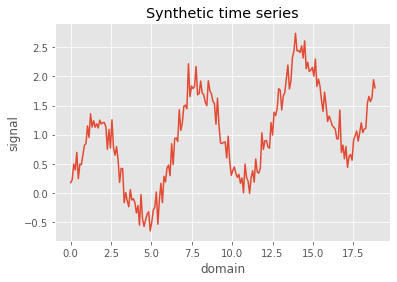

In [2]:
# A simple artificial time series consisting of trend, periodic and noise component
num_samples = 200
num_periods = 3
sample_span = [0,2*num_periods*np.pi]
trend_strength = 0.1
periodic_strength = 1.0
noise_strength = 0.2
domain = np.linspace(sample_span[0],sample_span[1],num_samples)
signal = trend_strength*domain+\
         periodic_strength*np.sin(domain)+\
         noise_strength*np.random.randn(num_samples)                       


plt.plot(domain,signal)
plt.ylabel('signal')
plt.xlabel('domain')
plt.title('Synthetic time series')
plt.show()

The function `create_sequences()` creates the training subsequences of length `train_window_size` and a target sample which is the next in sequence.

In [3]:
# Function for creating the training sequences
def create_sequences(input_data, tw):
    seq = []
    L = len(input_data)
    for i in range(L-tw):
        # Allow both multiple and single time series
        # In case of multiple time series, we assume that the labels are drawn from the first time series!
        if len(input_data.size())==1:
            train_sequence = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
        else:
            train_sequence = input_data[i:i+tw,:]
            train_label = input_data[i+tw:i+tw+1,1]
        seq.append((train_sequence ,train_label))
    return seq

In [4]:
# Remove the last test_size samples from the training set
test_size = 50

# 1.2. FINISH THE CODE - define train and test datasets!
train = signal[-test_size:]
test  = signal[:-test_size]

We will be scaling our data to the $[-1,1]$ range using the [`sklearn.preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [5]:
# Scale the data to the range -1 to 1

# 1.3. FINISH THE CODE - define a MinMaxScaler with feature range -1 to 1
scaler = MinMaxScaler(feature_range=(-1,1))

train_norm = scaler.fit_transform(train.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm[:10]

tensor([0.8151, 0.9204, 0.7301, 1.0000, 0.5600, 0.6620, 0.5152, 0.5363, 0.5809,
        0.4415])

In [6]:
train_window_size = 14
train_sequence = create_sequences(train_norm, train_window_size)
train_sequence[:3]

[(tensor([0.8151, 0.9204, 0.7301, 1.0000, 0.5600, 0.6620, 0.5152, 0.5363, 0.5809,
          0.4415, 0.7131, 0.2785, 0.3941, 0.2855]), tensor([0.0596])),
 (tensor([0.9204, 0.7301, 1.0000, 0.5600, 0.6620, 0.5152, 0.5363, 0.5809, 0.4415,
          0.7131, 0.2785, 0.3941, 0.2855, 0.0596]),
  tensor([-0.1151])),
 (tensor([ 0.7301,  1.0000,  0.5600,  0.6620,  0.5152,  0.5363,  0.5809,  0.4415,
           0.7131,  0.2785,  0.3941,  0.2855,  0.0596, -0.1151]),
  tensor([0.1892]))]

Here we will create our LSTM model class which will inherit from the [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class from the PyTorch library. The initial configuration for our model will take following inputs:

- `input_size` - Number of features in input. Our sequence is of length `train_window_size` but the actual input to the model is equal to 1 because we only have a single time series.
- `hidden_layer_size` - the number of hidden layers along with the number of neurons in each layer.
- `output_size` - Number of outputs. We will set it to 1 as we are only predicting one additional sample in the future. Predicting farther into the future will be performed by iterativelly calling our model on already predicted sample.

In [7]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

As we are doing a regression we will use mean squared error loss implemented in [`nn.MSELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).

In [8]:
learning_rate = 0.001
input_size = 1 # number of time series features in input
hidden_layer_size = 100 # size of the hidden layers, we only have one hidden layer with 100 neurons
output_size = 1 # number of outputs, we only predict one day in the future

model = LSTM(input_size,hidden_layer_size,output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We will do the model training for a specified number of epochs, storing the intermediary losses for later plotting. We expect that the loss will decrease on average over time, which means that our model is successfully learning from input data.

In [14]:
# Train the model for the specified number of epochs
epochs = 100

loss_array = []
start_time = time.time()

# Make sure that model is in the train mode
model.train()
for i in range(epochs):
    for seq, labels in train_sequence:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        # 1.4. FINISH THE CODE - apply your model to the current sequence and calculate the loss
        y_pred = model.forward(seq)
        loss   = loss_function(y_pred, labels)
        
        loss.backward()
        optimizer.step()
        
    if (i+1)%5 == 0:
        seconds = (time.time()-start_time)
        print(f'\repoch: {(i+1):3}/{epochs:3} loss: {loss.item():10.8f}, time elapsed: {seconds:.0f} s',end='')
        loss_array.append([i,loss.item()])

epoch: 100/100 loss: 0.00232333, time elapsed: 16 s

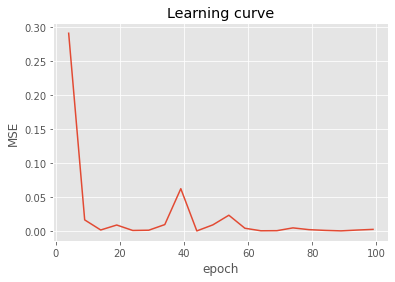

In [15]:
plt.plot([x[0] for x in loss_array],[x[1] for x in loss_array])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title('Learning curve')
plt.show()

After the initial training we will run the training for several more epochs in order to get multiple forecasting models. By plotting all of their predictions together we will get an estimate of the variance of our models.

In [16]:
# Run several more epochs and output their predictions
predictions_dict = {}
output_epochs = 30
start_time = time.time()
    
for i in range(output_epochs):
        
    # Step 1: Train the model for one more epoch

    # Make sure that model is in the train mode
    model.train()
    for seq, labels in train_sequence:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        # 1.5. FINISH THE CODE - apply your model to the current sequence and calculate the loss
        # NOTE - this part is identical to the one you already solved in previous exercise!
        y_pred = model.forward(seq)
        loss   = loss_function(y_pred, labels)
        
        loss.backward()
        optimizer.step()
    
    # Step 2: Test the model
    test_inputs = train_norm[-train_window_size:].tolist()

    # Set the model in evaluation (inference) mode
    model.eval()

    # Apply the model iterativelly to generate predictions in the future
    for j in range(test_size):
        seq = torch.FloatTensor(test_inputs[-train_window_size:])
        # Disable gradient computation during validation
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
            
    predictions_dict[i] = scaler.inverse_transform(np.array(test_inputs[train_window_size:] ).reshape(-1, 1))
    
    if (i+1)%5 == 0:
        seconds = (time.time()-start_time)
        print(f'\repoch: {(i+1):3}/{output_epochs:3}, time elapsed: {seconds:.0f} s',end='')

epoch:  30/ 30, time elapsed: 5 s

Lets plot all of the predictions from our model on a single figure.

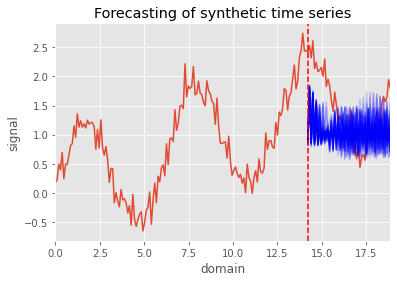

In [17]:
# Plotting multiple predictions
plt.title('Forecasting of synthetic time series')
plt.ylabel('signal')
plt.xlabel('domain')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(domain,signal)

for prediction in predictions_dict.values():
    plt.plot(domain[-test_size:],prediction,c='b',alpha=0.2)

plt.axvline(x=domain[-test_size], c='r', linestyle='--')
plt.show()

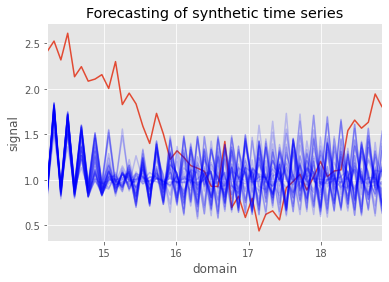

In [18]:
# Plotting multiple predictions on a restricted time scale
plt.title('Forecasting of synthetic time series')
plt.ylabel('signal')
plt.xlabel('domain')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(domain[-test_size:],signal[-test_size:])

for prediction in predictions_dict.values():
    plt.plot(domain[-test_size:],prediction,c='b',alpha=0.2)
    
plt.show()

Finally, we will plot the same mutliple predictions as before but we will superimpose the kernel density function on top of it to better visualize predictions which appear in multiple models.

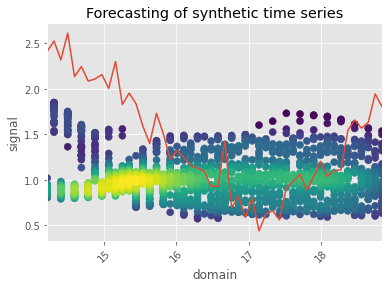

In [19]:
# Plotting predictions as a density estimation

# Construct the point arrays on which density will be estimated
x = np.array([])
y = np.array([])
d = np.array([])
for prediction in predictions_dict.values():
    d = np.append(d,domain[-test_size:])
    x = np.append(x,np.arange(test_size))
    y = np.append(y,prediction)

# Calculate the density through Gaussian kernel density estimation
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z, d = x[idx], y[idx], z[idx], d[idx]

# Plot the original time series
fig, ax = plt.subplots()
plt.title('Forecasting of synthetic time series')
plt.ylabel('signal')
plt.xlabel('domain')
ax.grid(True)
ax.autoscale(axis='x', tight=True)

# Plot the density estimations
ax.plot(domain[-test_size:],signal[-test_size:])
ax.scatter(d, y, c=z, s=50)

plt.xticks(rotation=45)
plt.show()

## 2. Forecasting Bitcoin price data

In this exercise we will be doing a time series forecasting of Bitcoin price. The CSV dataset of Bitcoin price is downloaded from [Coincodex](https://coincodex.com/crypto/bitcoin/historical-data/) - make sure that you have `bitcoin_2017-11-10_2022-11-09.csv` in the same folder as this notebook. For simplicity we will restrict the training of the model on the last `sample_size` samples, but you can run it on the whole time series.

The training and testing procedure is identical as in the example with the synthetic time series, and we will be using the same `create_sequences()` function and `LSTM` model as before.

In [20]:
# Number of time series samples we will use for analysis
sample_size = 200

# Load Bitcoin price data from CSV file 
# NOTE the data is within the repository under the Lecture 12 Economics and Finance + ML in blockchain applications folder
from google.colab import files
import io
uploaded = files.upload()
price = pd.read_csv(io.StringIO(uploaded['bitcoin_2017-11-10_2022-11-09.csv'].decode('utf-8')), index_col = 'Date', parse_dates=True)
price = price.iloc[::-1] # Reverse rows so that earlier dates come first
price = price.iloc[-sample_size:] # We only take sample_size most recent data points
price

Saving bitcoin_2017-11-10_2022-11-09.csv to bitcoin_2017-11-10_2022-11-09.csv


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2022-04-23,39441.658300,39846.010900,39140.663900,39479.996970,3.918160e+10,7.537304e+11
2022-04-24,39464.998265,40567.890400,38209.396100,40475.275211,5.868300e+10,7.461300e+11
2022-04-25,40420.005235,40704.663466,37768.639787,38026.746256,6.755552e+10,7.546296e+11
2022-04-26,38115.302300,39364.623600,38028.062900,39248.439282,7.361872e+10,7.382888e+11
2022-04-27,39235.765100,40306.952155,38935.672800,39749.938600,6.583411e+10,7.535602e+11
...,...,...,...,...,...,...
2022-11-04,21145.628000,21461.079439,21095.760300,21281.585100,9.393090e+10,4.088575e+11
2022-11-05,21302.329700,21350.988100,20913.053900,20913.053900,5.482829e+10,4.066266e+11
2022-11-06,20918.172300,21042.870300,20447.279500,20591.745900,7.525507e+10,3.980706e+11


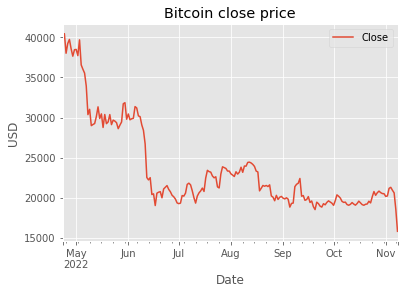

In [21]:
# Plot Bitcoin Close price time series
ax = price['Close'].plot(ylabel='USD', title='Bitcoin close price')
ax.legend()
plt.show()

In [22]:
# Extract Bitcoin Close data on which we will do forecasting
close = price[['Close']].to_numpy().flatten()
close[:20]

array([39479.99697027, 40475.27521136, 38026.7462556 , 39248.43928178,
       39749.9386    , 38592.00441699, 37660.45292214, 38467.094     ,
       38503.90959019, 37732.29975232, 39699.03395918, 36568.7596    ,
       36033.0634    , 35552.564     , 33933.54281003, 30363.86561662,
       31024.7033    , 28984.5358    , 29130.0386    , 29250.004     ])

In [23]:
# Remove the last test_size samples from the training set
test_size = 50

# 2.1. FINISH THE CODE - define train and test datasets!
train = close[-test_size:]
test  = close[:-test_size]

In [24]:
# Scale the data to the range -1 to 1

# 2.2. FINISH THE CODE - define a MinMaxScaler with feature range -1 to 1
scaler = MinMaxScaler(feature_range=(-1,1))

train_norm = scaler.fit_transform(train.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm[:10]

tensor([-0.0123,  0.3254,  0.2587,  0.1443,  0.1014,  0.2561,  0.2050,  0.3146,
         0.3852,  0.3329])

In [25]:
train_window_size = 14
train_sequence = create_sequences(train_norm, train_window_size)
train_sequence[:3]

[(tensor([-0.0123,  0.3254,  0.2587,  0.1443,  0.1014,  0.2561,  0.2050,  0.3146,
           0.3852,  0.3329,  0.2803,  0.1820,  0.3914,  0.6570]),
  tensor([0.5947])),
 (tensor([0.3254, 0.2587, 0.1443, 0.1014, 0.2561, 0.2050, 0.3146, 0.3852, 0.3329,
          0.2803, 0.1820, 0.3914, 0.6570, 0.5947]), tensor([0.5145])),
 (tensor([0.2587, 0.1443, 0.1014, 0.2561, 0.2050, 0.3146, 0.3852, 0.3329, 0.2803,
          0.1820, 0.3914, 0.6570, 0.5947, 0.5145]), tensor([0.3633]))]

In [26]:
learning_rate = 0.001
input_size = 1 # number of time series features in input
hidden_layer_size = 100 # size of the hidden layers, we only have one hidden layer with 100 neurons
output_size = 1 # number of outputs, we only predict one day in the future

model = LSTM(input_size,hidden_layer_size,output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model for the specified number of epochs
epochs = 100

loss_array = []
start_time = time.time()

# Make sure that model is in the train mode
model.train()
for i in range(epochs):
    for seq, labels in train_sequence:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        
        # 2.3. FINISH THE CODE - apply your model to the current sequence and calculate the loss
        y_pred = model.forward(seq)
        loss   = loss_function(y_pred, labels)
        
        loss.backward()
        optimizer.step()
        
    if (i+1)%5 == 0:
        seconds = (time.time()-start_time)
        print(f'\repoch: {(i+1):3}/{epochs:3} loss: {loss.item():10.8f}, time elapsed: {seconds:.0f} s',end='')
        loss_array.append([i,loss.item()])

epoch: 100/100 loss: 0.01686676, time elapsed: 14 s

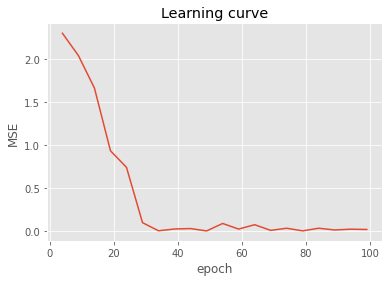

In [27]:
plt.plot([x[0] for x in loss_array],[x[1] for x in loss_array])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title('Learning curve')
plt.show()

In [28]:
# Run several more epochs and output their predictions
predictions_dict = {}
output_epochs = 30
start_time = time.time()
    
for i in range(output_epochs):
        
    # Step 1: Train the model for one more epoch

    # Make sure that model is in the train mode
    model.train()
    for seq, labels in train_sequence:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        # 2.4. FINISH THE CODE - apply your model to the current sequence and calculate the loss
        # NOTE - this part is identical to the one you already solved in previous exercise!
        y_pred = model.forward(seq)
        loss   = loss_function(y_pred, labels)
        
        loss.backward()
        optimizer.step()
    
    # Step 2: Test the model
    test_inputs = train_norm[-train_window_size:].tolist()

    # Set the model in evaluation (inference) mode
    model.eval()

    # Apply the model iterativelly to generate predictions in the future
    for j in range(test_size):
        seq = torch.FloatTensor(test_inputs[-train_window_size:])
        # Disable gradient computation during validation
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
            
    predictions_dict[i] = scaler.inverse_transform(np.array(test_inputs[train_window_size:] ).reshape(-1, 1))
    
    if (i+1)%5 == 0:
        # print(f'epoch: {i:3}')
        seconds = (time.time()-start_time)
        print(f'\repoch: {(i+1):3}/{output_epochs:3}, time elapsed: {seconds:.0f} s',end='')

epoch:  30/ 30, time elapsed: 5 s

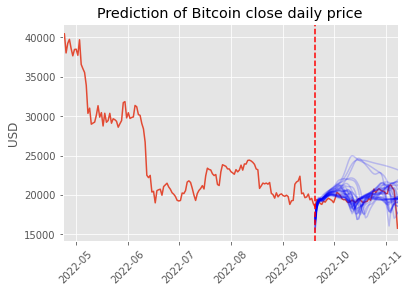

In [29]:
# Plotting multiple predictions
plt.title('Prediction of Bitcoin close daily price')
plt.ylabel('USD')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(price['Close'])

for prediction in predictions_dict.values():
    plt.plot(price.index[-test_size:],prediction,c='b',alpha=0.2)

plt.axvline(x=price.index[-test_size], c='r', linestyle='--')
plt.xticks(rotation=45)
plt.show()

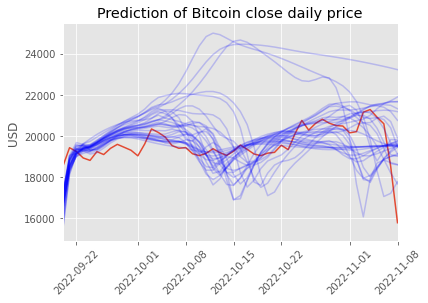

In [30]:
# Plotting multiple predictions on a restricted time scale
plt.title('Prediction of Bitcoin close daily price')
plt.ylabel('USD')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(price['Close'][-test_size:])

for prediction in predictions_dict.values():
    plt.plot(price.index[-test_size:],prediction,c='b',alpha=0.2)
    
plt.xticks(rotation=45)
plt.show()

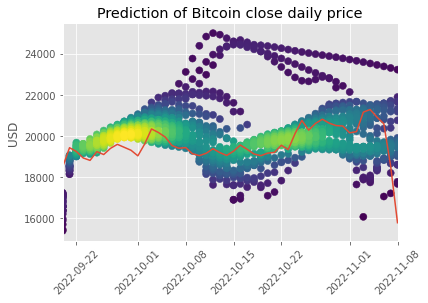

In [31]:
# Plotting predictions as a density estimation

# Construct the point arrays on which density will be estimated
x = np.array([])
y = np.array([])
d = np.array([],dtype=np.datetime64)
for prediction in predictions_dict.values():
    d = np.append(d,price.index[-test_size:].values)
    x = np.append(x,np.arange(test_size))
    y = np.append(y,prediction)

# Calculate the density through Gaussian kernel density estimation
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z, d = x[idx], y[idx], z[idx], d[idx]

# Plot the original time series
fig, ax = plt.subplots()
ax.set_title('Prediction of Bitcoin close daily price')
ax.set_ylabel('USD')
ax.grid(True)
ax.autoscale(axis='x', tight=True)

# Plot the density estimations
ax.plot(price['Close'][-test_size:])
ax.scatter(d, y, c=z, s=50)

plt.xticks(rotation=45)
plt.show()